# <b>Retinal Blood Vessel Segmentation</b>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import glob
import copy
%matplotlib inline
import skimage.filters
import skimage.exposure
import skimage.filters.rank
import skimage.morphology
import scipy.ndimage
import os
import matplotlib.image as img
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.filters import hessian
from skimage import morphology

In [2]:
link = []
link = glob.glob('dataset/*.ppm')

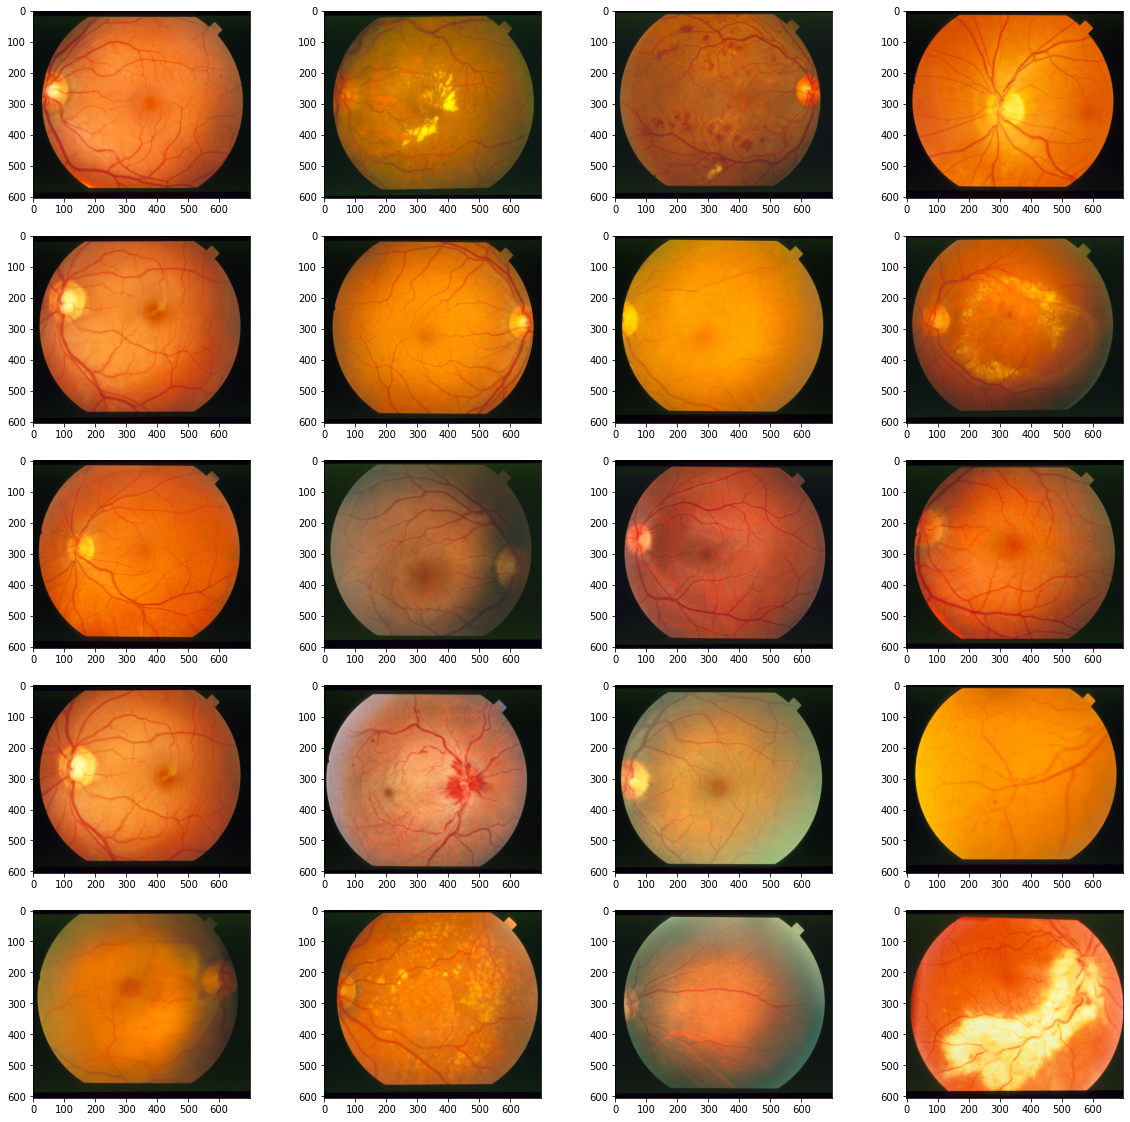

In [3]:
#checking the input data
rows = 5
columns = 4
fig = plt.figure(figsize=(20, 20))
for i in range(1, 21):
    fig.add_subplot(rows, columns, i)
    img = cv2.imread(link[i-1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img,cmap='gray')

plt.show()

In [4]:
print(img.shape)

(605, 700, 3)


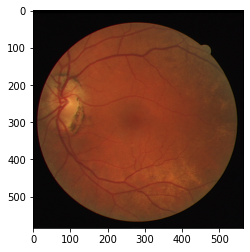

In [5]:
url = "dataset/26_training.tif"
img = cv2.imread(url)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
#channel splitting
imgR = img[:,:,0]
imgG = img[:,:,1]
imgB = img[:,:,2]

Text(0.5, 1.0, 'Blue Channel')

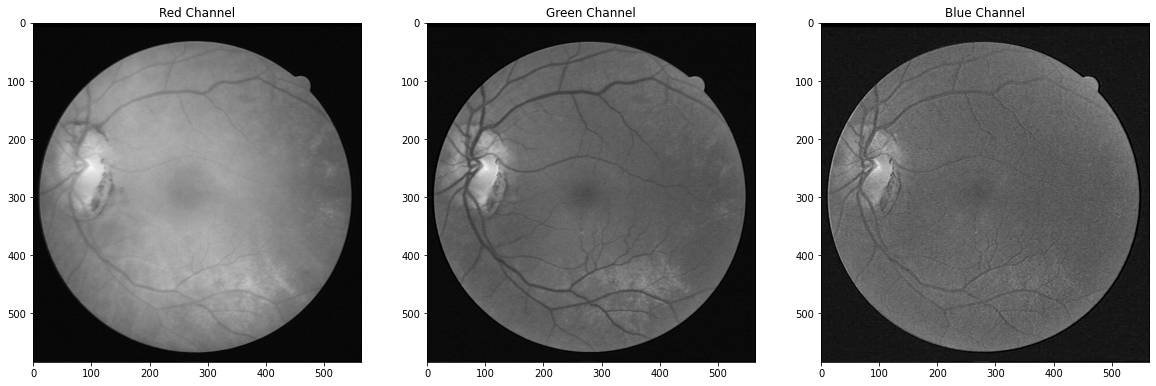

In [7]:
#plotting the different channels
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(imgR,cmap='gray')
plt.title('Red Channel')
fig.add_subplot(1, 3, 2)
plt.imshow(imgG,cmap='gray')
plt.title('Green Channel')
fig.add_subplot(1, 3, 3)
plt.imshow(imgB,cmap='gray')
plt.title('Blue Channel')

In [8]:
#histogram function, returns list with frequencies
def drawHistogram(img):
    his = np.zeros(256,)
    a = img.flatten()
    for i in a:
        his[i] = his[i]+1
    return his

(array([9.2000e+01, 6.8470e+03, 7.8900e+02, 1.0160e+03, 2.0990e+03,
        8.5510e+03, 1.3814e+04, 2.5904e+04, 1.6235e+04, 1.9784e+04,
        7.1350e+03, 2.3040e+03, 1.2070e+03, 5.9700e+02, 1.0910e+03,
        8.6700e+02, 1.3520e+03, 1.0950e+03, 1.7360e+03, 1.3930e+03,
        2.3400e+03, 3.0280e+03, 2.4320e+03, 4.5160e+03, 3.6010e+03,
        6.2400e+03, 4.8270e+03, 8.3720e+03, 6.2530e+03, 1.0228e+04,
        1.1216e+04, 7.7610e+03, 1.1904e+04, 8.2590e+03, 1.2783e+04,
        8.5420e+03, 1.2971e+04, 8.5420e+03, 1.1919e+04, 7.4250e+03,
        1.0414e+04, 9.0720e+03, 5.2260e+03, 6.8660e+03, 3.7700e+03,
        4.7750e+03, 2.6140e+03, 3.3370e+03, 1.8570e+03, 2.2130e+03,
        1.7740e+03, 9.5200e+02, 1.1910e+03, 5.9400e+02, 7.8100e+02,
        4.7400e+02, 6.2400e+02, 3.5100e+02, 5.5000e+02, 3.2600e+02,
        4.5400e+02, 3.9300e+02, 2.3900e+02, 3.2200e+02, 1.9300e+02,
        2.5500e+02, 1.7200e+02, 2.9800e+02, 1.7700e+02, 2.6100e+02,
        2.3600e+02, 1.5700e+02, 2.0300e+02, 1.22

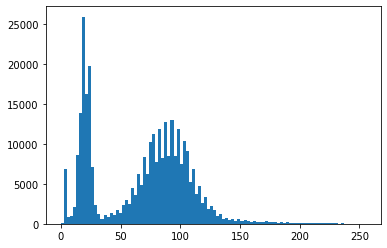

In [9]:
#clahe operation on the Green channel of image
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(imgG)
plt.hist(clahe_img.flat, bins=100, range=(0,255))

Text(0.5, 1.0, 'Applying CLAHE')

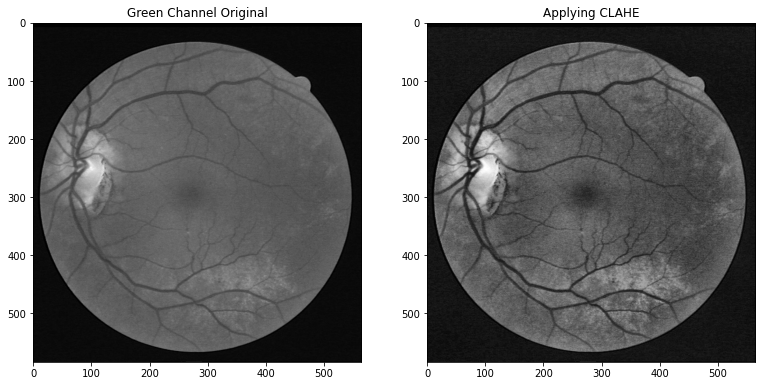

In [10]:
#checking effect of Clahe
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(imgG,cmap='gray')
plt.title('Green Channel Original')
fig.add_subplot(1, 3, 2)
plt.imshow(clahe_img,cmap='gray')
plt.title('Applying CLAHE')

In [11]:
#morphological operations, Here we do opening then closing
cell_disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
Topen = cv2.morphologyEx(clahe_img,cv2.MORPH_OPEN,cell_disc)
Tclose = cv2.morphologyEx(Topen, cv2.MORPH_CLOSE, cell_disc)
# cell_disc1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# Tclose = cv2.morphologyEx(Topen, cv2.MORPH_DILATE, cell_disc1)

#gtting the tophat image
TopHat = (clahe_img - Tclose)#.astype(np.uint8)

Text(0.5, 1.0, 'Green Channel Original')

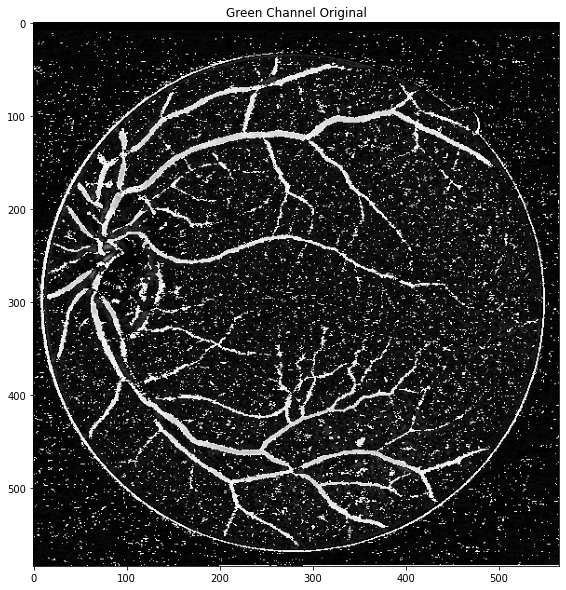

In [12]:
#checking the tophat image
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 1, 1)
plt.imshow(TopHat,cmap='gray')
plt.title('Green Channel Original')

Text(0.5, 1.0, 'Green Channel Original')

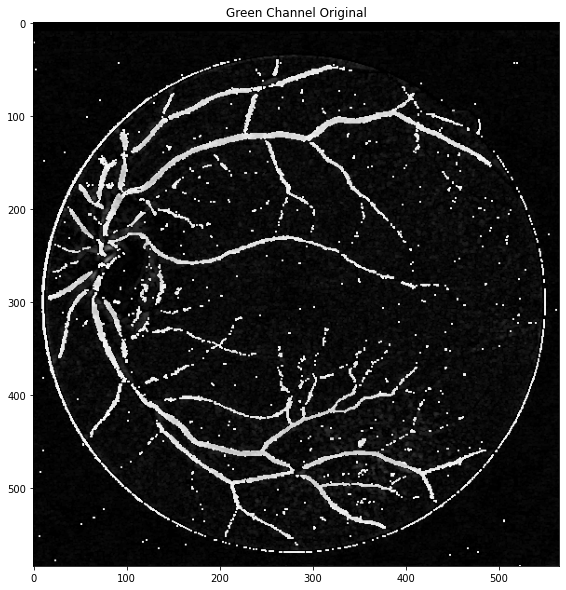

In [13]:
#More morphological operations, erosion then dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
min_image = cv2.erode(TopHat, kernel)
min_image = cv2.dilate(min_image, kernel)
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 1, 1)
plt.imshow(min_image,cmap='gray')
plt.title('Green Channel Original')

# Hessian Matrix

In [14]:
#thresholding function
def threshold(img,k):
    ret = copy.deepcopy(img)
    ret[ret<k] = 0
    ret[ret>=k] = 255
    return ret

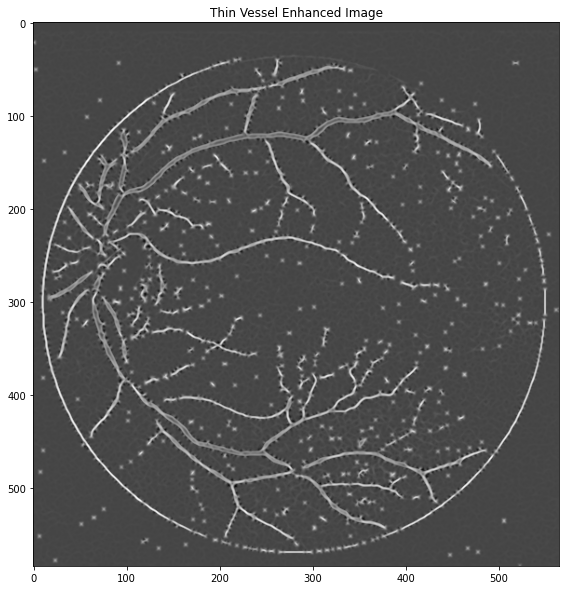

In [15]:
#hessian matrix and eigenvalues approach to get thin vessel enhanced image
HessThin = hessian_matrix(min_image, sigma=1.2, order='rc')
EignThin = hessian_matrix_eigvals(HessThin) [1]
fig = plt.figure(figsize=(20, 10))
plt.title("Thin Vessel Enhanced Image")
plt.imshow(1-EignThin, cmap=plt.cm.gray)

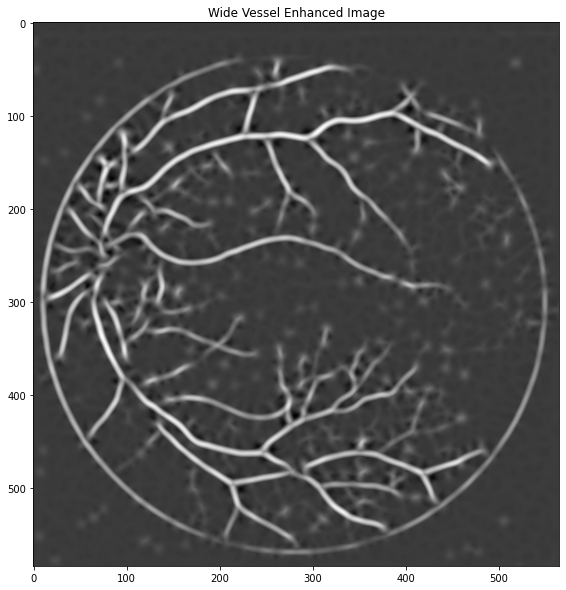

In [16]:
#hessian matrix and eigenvalues approach to get wide vessel enhanced image
HessWide = hessian_matrix(min_image, sigma=4, order='rc')
EignWide = hessian_matrix_eigvals(HessWide) [1]
fig = plt.figure(figsize=(20, 10))
plt.title("Wide Vessel Enhanced Image")
plt.imshow(1-EignWide, cmap='gray')

In [17]:
#global otsu thresholding function
def GlobalOtsu(img):
    foreground = img[img>=0]
    background = img[img<0]
    
    final_var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
    if(np.isnan(final_var)):
        final_var = -1
        
    final_thresh = 0
    for i in np.linspace(np.min(img), np.max(img), num=255):
        foreground = img[img>=i]
        background = img[img<i]
        var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
        
        if(np.isnan(var)):
            var = -1
            
        if(var!=-1 and (var<final_var or final_var ==-1)):
            final_var = var
            final_thresh = i
    return threshold(img,final_thresh)

In [18]:
#Area based thresholding/cleaning. Done as postprocessing step
def AreaThreshold(img, area = 5):
    nlabels,labels,stats,centroid = cv2.connectedComponentsWithStats(np.uint8(img), 4, cv2.CV_32S)

    output = np.copy(img)
    
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if stats[labels[i][j], cv2.CC_STAT_AREA] < area:
                output[i][j] = 0
                
    return output

In [19]:
#Local otsu thresholding
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk

def LocalOtsu1(img,radius = 5):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    
    output[output < local_otsu] = 0
    output[output >= local_otsu] = 255
    
    return output

In [20]:
#local Otsu thresholding function as per paper with offset included
def LocalOtsu2(img,radius = 15):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    rng = local_otsu.max() - local_otsu.min()
    mid = rng/2 + local_otsu.min()

    local_otsu[local_otsu<mid] = mid

    output[output < local_otsu] = 0


    return output

In [21]:
#different accuracy metrics used are returned by this function
def AccuracyMetrics(img,imggt):
    matches = np.copy(img[img==imggt])
    mismatches = np.copy(img[img!=imggt])
    TP = sum(matches==255)
    TN = sum(matches==0)
    FP = sum(mismatches==255)
    FN = sum(mismatches==0)
#     print(matches.shape)
#     print(mismatches.shape)
#     print("TP ",TP)
#     print("TN ",TN)
#     print("FP ",FP)
#     print("FN ",FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    Sn = TP/(TP+FN)
    Sp = TN/(TN+FP)
    Auc = (Sn+Sp)/2
    
    return Acc,Sn,Sp,Auc

In [22]:
import pywt

#using wavelet method for image fusion
def image_fusion(img1,img2):
    w1 = pywt.wavedec2(img1, 'db1')
    w2 = pywt.wavedec2(img2, 'db1')
    elem = (w1[0]+w2[0])/2
    fw = [elem]
    
    for i in range(len(w1)-1):
        x,y,z = (w1[i+1][0] + w2[i+1][0])/2, (w1[i+1][1] + w2[i+1][1])/2, (w1[i+1][2] + w2[i+1][2])/2
        fw.append((x,y,z))

    output = pywt.waverec2(fw, 'db1')
    
#     Normalisation, May or May not be required
    amin = np.min(output)
    amax = np.max(output)
    output = 255* ((output - amin)/(amax-amin))
    
    output = cv2.resize(output,img1.T.shape)
    return output

In [23]:
#Global otsu thresholding
val1 = GlobalOtsu(1-EignWide)

/home/seikh/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/seikh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/seikh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'GlobalThresholdedThickVessel')

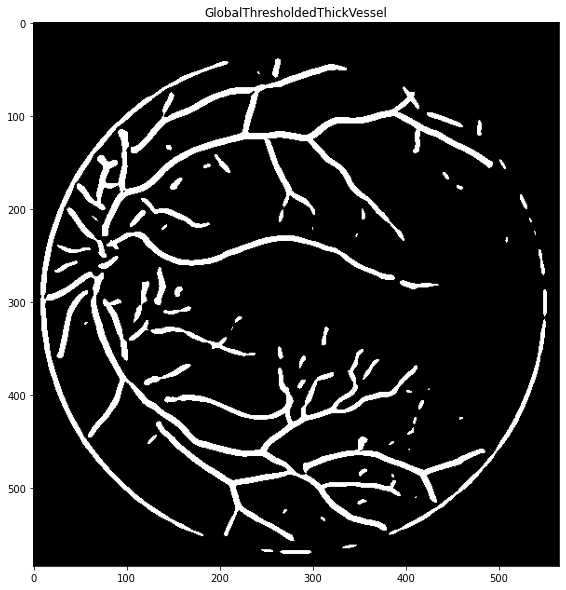

In [24]:
#Global otsu thresholded image
fig = plt.figure(figsize=(10, 10))
plt.imshow(val1,cmap='gray')
plt.title("GlobalThresholdedThickVessel")

In [25]:
#normalising the images for further processing
thinN = cv2.normalize(1-EignThin,  None, 0, 255, cv2.NORM_MINMAX)
val1 = cv2.normalize(val1,  None, 0, 70, cv2.NORM_MINMAX)

Text(0.5, 1.0, 'Thin vessels enhanced')

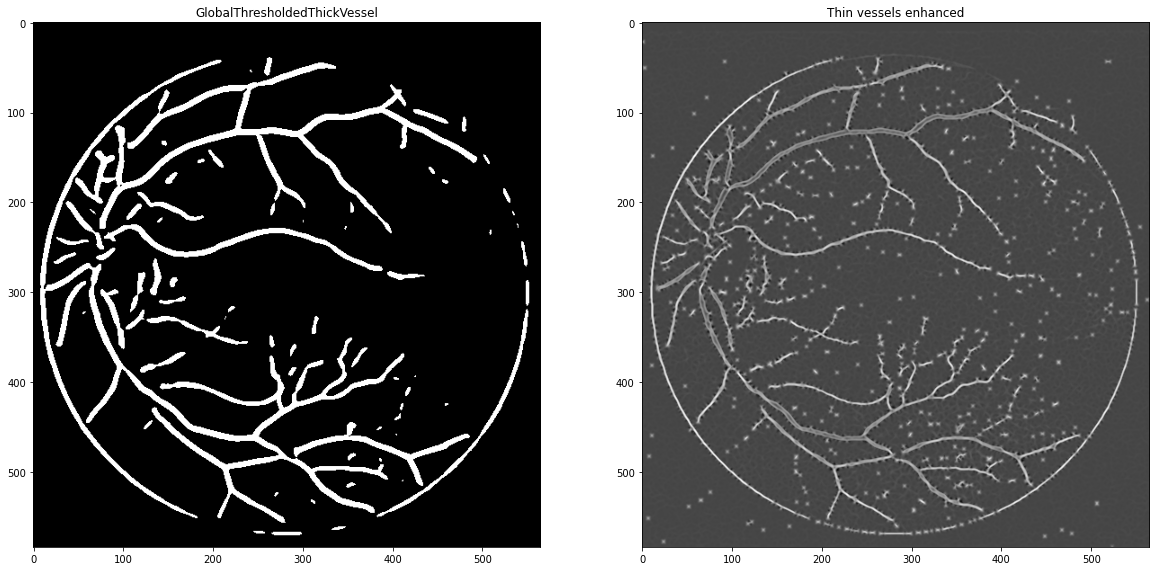

In [26]:
#Two images that have to be fused
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(val1,cmap='gray')
plt.title('GlobalThresholdedThickVessel')
fig.add_subplot(1, 2, 2)
plt.imshow(thinN,cmap='gray')
plt.title('Thin vessels enhanced')

In [27]:
#fusing the images
test1 = image_fusion(val1,thinN)

Text(0.5, 1.0, 'Image Fusion')

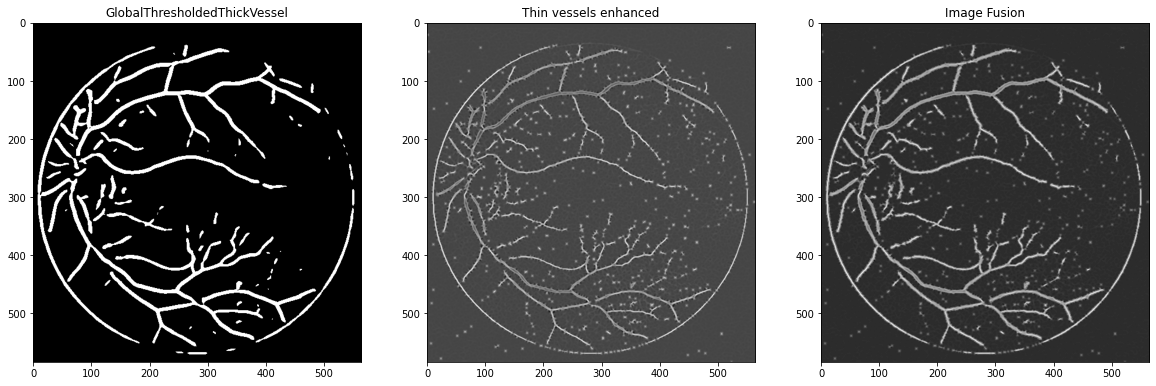

In [28]:
#comparing the fused image with originals
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(val1,cmap='gray')
plt.title('GlobalThresholdedThickVessel')
fig.add_subplot(1, 3, 2)
plt.imshow(thinN,cmap='gray')
plt.title('Thin vessels enhanced')
fig.add_subplot(1, 3, 3)
plt.imshow(test1,cmap='gray')
plt.title("Image Fusion")

Text(0.5, 1.0, 'Local Otsu Thresholding')

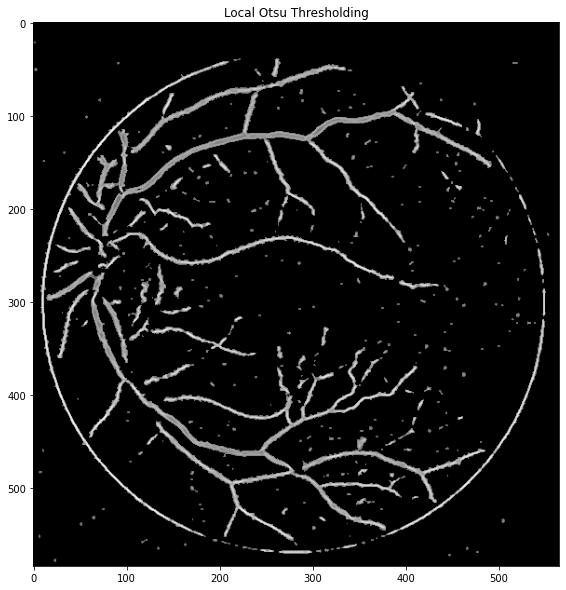

In [29]:
#local otsu thresholding on the fused image
lOtsu = LocalOtsu2(test1.astype('uint8'))
fig = plt.figure(figsize=(10, 10))
plt.imshow(lOtsu,cmap='gray')
plt.title("Local Otsu Thresholding")

Text(0.5, 1.0, 'Pixel/Area based Thresholding')

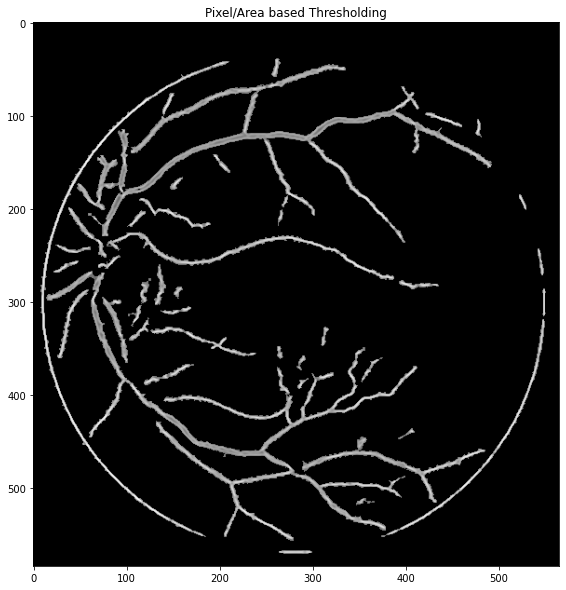

In [30]:
#area thresholding to remove non vessel regions
final = AreaThreshold(lOtsu,50)
fig = plt.figure(figsize=(10, 10))
plt.imshow(final,cmap='gray')
plt.title("Pixel/Area based Thresholding")

Text(0.5, 1.0, 'Final Output')

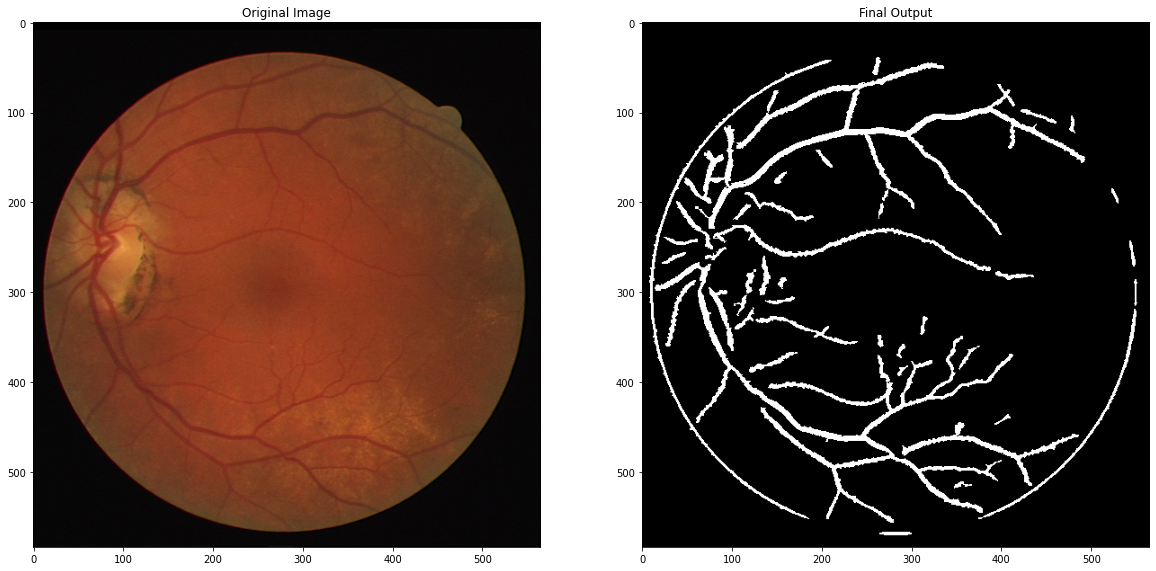

In [31]:
#binarizing final output and visualising it

final[final!=0] = 255
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(final,cmap='gray')
# plt.title("Final Output")

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(final,cmap='gray')
plt.title("Final Output")

In [33]:
#Ground truth image
imgRef = cv2.imread("testing/labels-ah/"+url[-10:-3]+"ah.ppm")
imgRef = imgRef(:,:,1)
# plt.imshow(imgRef,cmap='gray')

SyntaxError: invalid syntax (916998164.py, line 3)

In [ ]:
# checking the accuracy metrics for our image with the ground truth
Acc1,Sn1,Sp1,Auc1 = AccuracyMetrics(final,imgRef)
print("Accuracy: ",Acc1)
print("Sensitivity: ",Sn1)
print("Specificity: ",Sp1)
print("Area Under Curve(AUC): ",Auc1)